Files already downloaded and verified


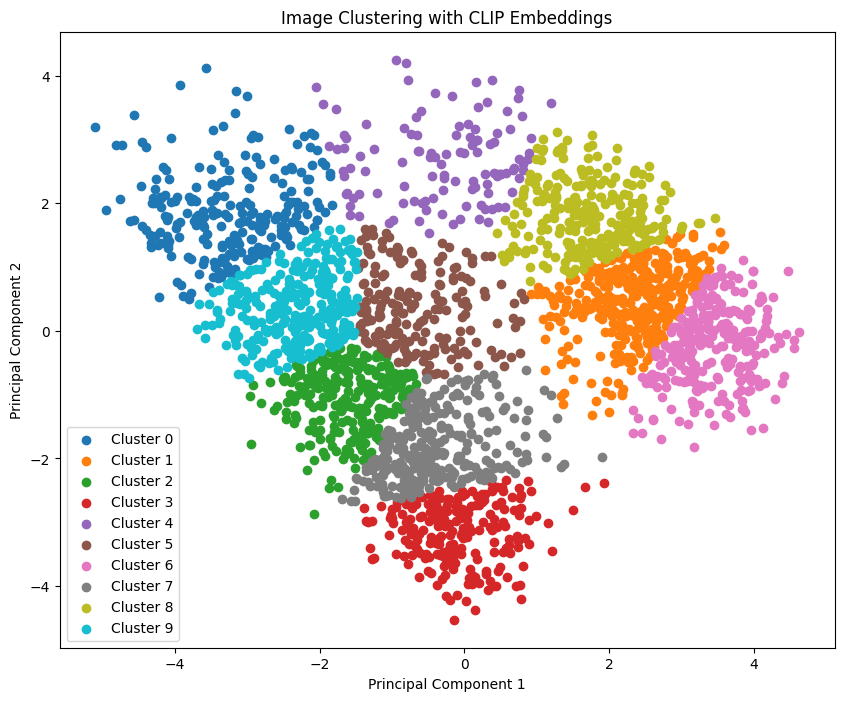

In [10]:
# Install necessary libraries
!pip install transformers torchvision scikit-learn matplotlib

# Import required libraries
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import Subset
# Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Preprocessing for CIFAR-10 dataset
transform = Compose([
    Resize((224, 224)),  # Resize to 224x224 for CLIP
    ToTensor()  # Only convert to tensor, do not normalize
])

# Load CIFAR-10 dataset
dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(dataset), size=int(0.05 * len(dataset)), replace=False)
subset = Subset(dataset, subset_indices)
dataloader = torch.utils.data.DataLoader(subset, batch_size=128, shuffle=False)

# Extract image embeddings using CLIP
embeddings = []
image_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        inputs = processor(images=list(images), return_tensors="pt", padding=True, do_rescale=False)  # Disable rescaling
        outputs = model.get_image_features(**inputs)
        embeddings.append(outputs.cpu().numpy())
        image_labels.extend(labels.numpy())


# Flatten the embeddings list
import numpy as np
embeddings = np.vstack(embeddings)

# Perform dimensionality reduction with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Perform KMeans clustering
n_clusters = 10  # CIFAR-10 has 10 classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    cluster_points = reduced_embeddings[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}")

plt.title("Image Clustering with CLIP Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()
